# AnyoneAI - Sprint Project 02
> Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all togheter. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.


## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [1]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, data_utils, preprocessing

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions. Then submit this dataset alongside this Jupyter notebook, AnyoneAI will internally evaluate your model's accuracy in the hidden data and communicate later ;).

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

**Don't change anything in this cell, just make it run correctly**

In [2]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis

A lot of the analysis of the data can be found on publicly available Kaggle kernels or blog posts, but you need to make sure you understand the dataset's properties before starting working on it, so we'll do exploratory data analysis for the main files.

#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [3]:
# Cargar los archivos CSV
train_df = pd.read_csv("dataset/application_train_aai.csv")
test_df = pd.read_csv("dataset/application_test_aai.csv")

# Contar el número de filas en cada dataset
num_train_samples = train_df.shape[0]
num_test_samples = test_df.shape[0]

# Imprimir la cantidad de muestras en cada dataset
print(f" Número de muestras en el conjunto de entrenamiento: {num_train_samples}")
print(f" Número de muestras en el conjunto de prueba: {num_test_samples}")



 Número de muestras en el conjunto de entrenamiento: 246008
 Número de muestras en el conjunto de prueba: 61503


1.3. List all columns in the train dataset.

In [4]:
### TODO Complete in this cell: Show all columns in the training dataset
# List all columns in the training dataset
train_columns = train_df.columns

# Print the columns
print("Columns in the training dataset:")
print(train_columns)



Columns in the training dataset:
Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

For reference only, it should look like this:

|0|1|2|3|4
|---|---|---|---|---
Unnamed: 0|187399|84777|268140|270686|33785
SK_ID_CURR|317244|198357|410700|413785|139141
TARGET|0|0|0|0|0
NAME_CONTRACT_TYPE|Cash loans|Cash loans|Cash loans|Cash loans|Cash loans
...|...|...|...|...|...
AMT_REQ_CREDIT_BUREAU_DAY|0.0|0.0|0.0|0.0|0.0

In [5]:
### TODO Complete in this cell: show first 5 records in a transposed table
# The first 5 records transposed to display features as rows
first_five_transposed = train_df.head(5).T  # .T transposes the DataFrame

# Display the transposed DataFrame
print("First 5 records (transposed):")
first_five_transposed


First 5 records (transposed):


,0,1,2,3,4
SK_ID_CURR,428247,140966,407283,434300,446788
TARGET,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_MON,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_QRT,NaN,0.0,0.0,1.0,0.0


1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

 Distribution of TARGET variable:
TARGET
0    226257
1     19751
Name: count, dtype: int64

📊 Percentage distribution:
TARGET
0    91.971399
1     8.028601
Name: proportion, dtype: float64


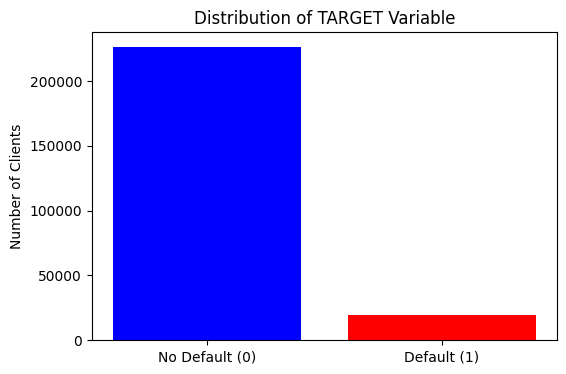

In [6]:
### TODO Complete in this cell: show distribution of target variable


# Count occurrences of each target value
target_counts = train_df["TARGET"].value_counts()
target_percentages = train_df["TARGET"].value_counts(normalize=True) * 100  # Convert to percentage

# Print counts and percentages
print(" Distribution of TARGET variable:")
print(target_counts)
print("\n📊 Percentage distribution:")
print(target_percentages)

# Plot the distribution
plt.figure(figsize=(6,4))
plt.bar(target_counts.index, target_counts.values, color=['blue', 'red'])
plt.xticks([0,1], ["No Default (0)", "Default (1)"])
plt.ylabel("Number of Clients")
plt.title("Distribution of TARGET Variable")
plt.show()



1.6. Show the number of columns of each data type.

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
float64    45
int64      32
object     10
```

In [7]:
### TODO Complete in this cell: show number of columns per data type
#  The number of columns per data type
column_types = train_df.dtypes.value_counts()

# Print
print("Number of columns per data type:")
print(column_types)


Number of columns per data type:
float64    65
int64      41
object     16
Name: count, dtype: int64


1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
NAME_CONTRACT_TYPE             5
CODE_GENDER                    2
FLAG_OWN_CAR                   1
FLAG_OWN_REALTY                1
...
```

In [8]:
### TODO Complete in this cell: show number of unique values per categorical column
# The number of unique values per categorical column
categorical_columns = train_df.select_dtypes(include=['object']).nunique()

# Print the result
print(" Number of unique values per categorical column:")
print(categorical_columns)



 Number of unique values per categorical column:
NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

Just for giving you an idea, the output should look like this (not exactly the same numbers and columns names):

```python
                   Total   Percent
COMMONAREA_AVG    121000      85.2
COMMONAREA_MODE   121000      76.6
COMMONAREA_MEDI   121000      62.9
...
```

In [9]:
### TODO Complete in this cell: checking missing data


# Load the dataset
train_df = pd.read_csv("dataset/application_train_aai.csv") 

# Calculate the total number of missing values per column
missing_values = train_df.isnull().sum()

# Calculate the percentage of missing values per column
missing_percentage = (missing_values / len(train_df)) * 100

# Create a DataFrame with the results
missing_data = pd.DataFrame({"Total": missing_values, "Percent": missing_percentage})

# Sort columns by missing percentage in descending order
missing_data = missing_data.sort_values(by="Percent", ascending=False)

# Display only the top 20 columns with the highest percentage of missing values
print(" Top 20 columns with the highest percentage of missing values:")
print(missing_data.head(20))



 Top 20 columns with the highest percentage of missing values:
                           Total    Percent
COMMONAREA_AVG            172189  69.993252
COMMONAREA_MODE           172189  69.993252
COMMONAREA_MEDI           172189  69.993252
NONLIVINGAPARTMENTS_MEDI  171096  69.548958
NONLIVINGAPARTMENTS_MODE  171096  69.548958
NONLIVINGAPARTMENTS_AVG   171096  69.548958
FONDKAPREMONT_MODE        168561  68.518503
LIVINGAPARTMENTS_AVG      168494  68.491269
LIVINGAPARTMENTS_MEDI     168494  68.491269
LIVINGAPARTMENTS_MODE     168494  68.491269
FLOORSMIN_MODE            167255  67.987626
FLOORSMIN_AVG             167255  67.987626
FLOORSMIN_MEDI            167255  67.987626
YEARS_BUILD_AVG           163980  66.656369
YEARS_BUILD_MODE          163980  66.656369
YEARS_BUILD_MEDI          163980  66.656369
OWN_CAR_AGE               162503  66.055982
LANDAREA_MEDI             146436  59.524893
LANDAREA_AVG              146436  59.524893
LANDAREA_MODE             146436  59.524893


#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

*Hint:* Take a look at `AMT_CREDIT` column.

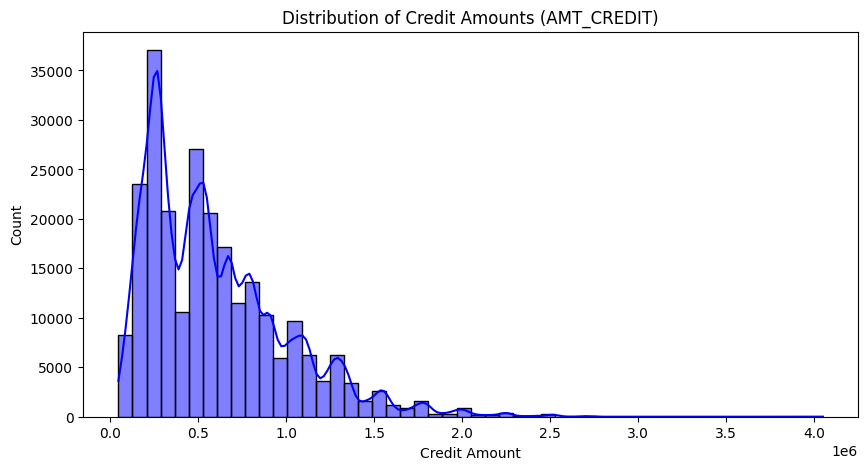

In [10]:
### TODO Complete in this cell: distribution of credit amounts

# Plot the distribution of AMT_CREDIT
plt.figure(figsize=(10, 5))
sns.histplot(train_df["AMT_CREDIT"].dropna(), bins=50, kde=True, color="blue")

# Add labels and title
plt.xlabel("Credit Amount")
plt.ylabel("Count")
plt.title("Distribution of Credit Amounts (AMT_CREDIT)")

# Show the plot
plt.show()


1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

*Hint:* Take a look at `NAME_EDUCATION_TYPE` column.

 Total count of each education level:
NAME_EDUCATION_TYPE
Secondary / secondary special    174657
Higher education                  59990
Incomplete higher                  8248
Lower secondary                    2984
Academic degree                     129
Name: count, dtype: int64

 Percentage distribution of education levels:
NAME_EDUCATION_TYPE
Secondary / secondary special    70.996472
Higher education                 24.385386
Incomplete higher                 3.352736
Lower secondary                   1.212969
Academic degree                   0.052437
Name: proportion, dtype: float64


C:\Users\pc\AppData\Local\Temp\ipykernel_5524\3921160663.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=education_counts.index, y=education_counts.values, palette="viridis")


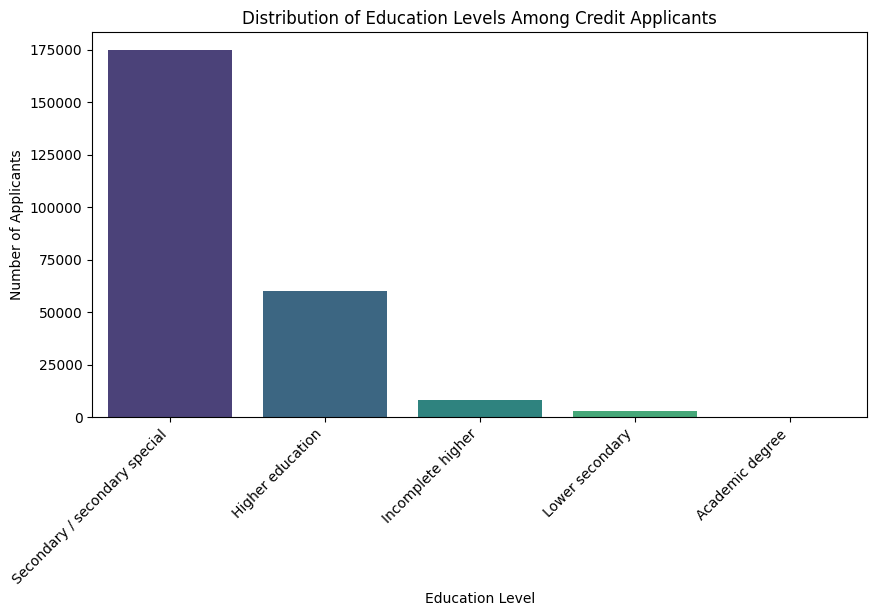

In [11]:
### TODO Complete in this cell: level of education plot

# Load the dataset 
train_df = pd.read_csv("dataset/application_train_aai.csv")  

# Count occurrences of each education level
education_counts = train_df["NAME_EDUCATION_TYPE"].value_counts()
education_percentages = train_df["NAME_EDUCATION_TYPE"].value_counts(normalize=True) * 100  # Convert to percentage

# Print counts and percentages
print(" Total count of each education level:")
print(education_counts)
print("\n Percentage distribution of education levels:")
print(education_percentages)

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=education_counts.index, y=education_counts.values, palette="viridis")

# Add labels and title
plt.xticks(rotation=45, ha="right")
plt.xlabel("Education Level")
plt.ylabel("Number of Applicants")
plt.title("Distribution of Education Levels Among Credit Applicants")

# Show the plot
plt.show()


1.11. Plot the distribution of ocupation of the loan applicants.

*Hint:* Take a look at `OCCUPATION_TYPE` column.

 Total count of each occupation type:
OCCUPATION_TYPE
Laborers                 44108
Sales staff              25770
Core staff               22041
Managers                 16992
Drivers                  14874
High skill tech staff     8981
Accountants               7915
Medicine staff            6879
Security staff            5364
Cooking staff             4771
Cleaning staff            3731
Private service staff     2140
Low-skill Laborers        1687
Waiters/barmen staff      1094
Secretaries               1043
Realty agents              625
IT staff                   443
HR staff                   431
Name: count, dtype: int64


C:\Users\pc\AppData\Local\Temp\ipykernel_5524\335132507.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=occupation_counts.index, y=occupation_counts.values, palette="viridis")


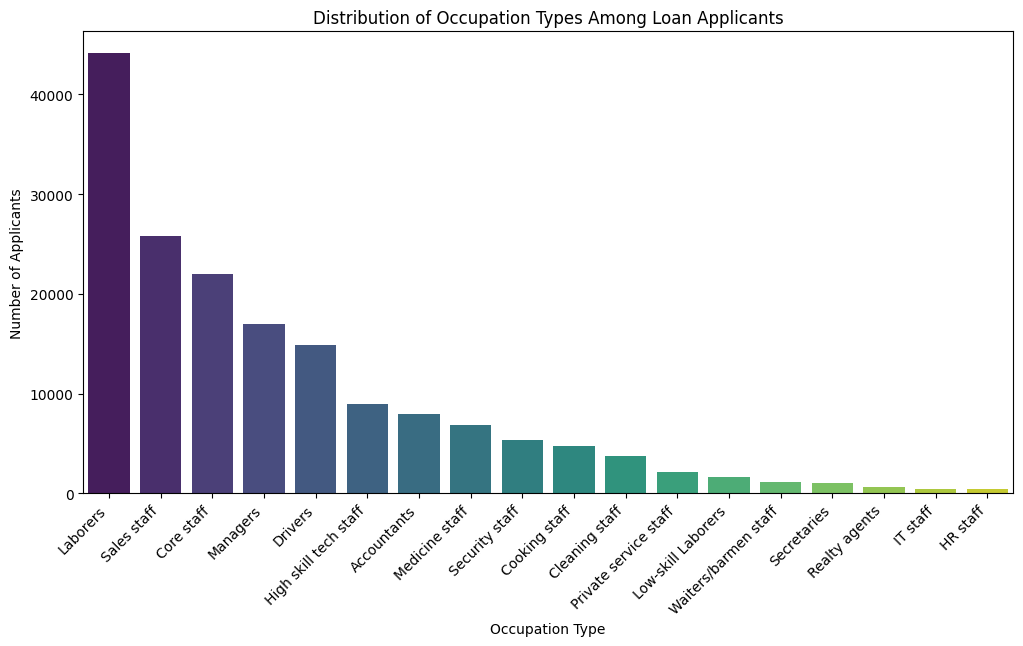

In [12]:
### TODO Complete in this cell: ocupation of applicants

# Count occurrences of each occupation
occupation_counts = train_df["OCCUPATION_TYPE"].value_counts()

# Print total counts
print(" Total count of each occupation type:")
print(occupation_counts)

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=occupation_counts.index, y=occupation_counts.values, palette="viridis")

# Add labels and title
plt.xticks(rotation=45, ha="right")
plt.xlabel("Occupation Type")
plt.ylabel("Number of Applicants")
plt.title("Distribution of Occupation Types Among Loan Applicants")

# Show the plot
plt.show()



1.12. Plot the family status of the applicants.

*Hint:* Take a look at `NAME_FAMILY_STATUS` column.

 Total count of each family status category:
NAME_FAMILY_STATUS
Married                 157165
Single / not married     36315
Civil marriage           23841
Separated                15803
Widow                    12883
Unknown                      1
Name: count, dtype: int64


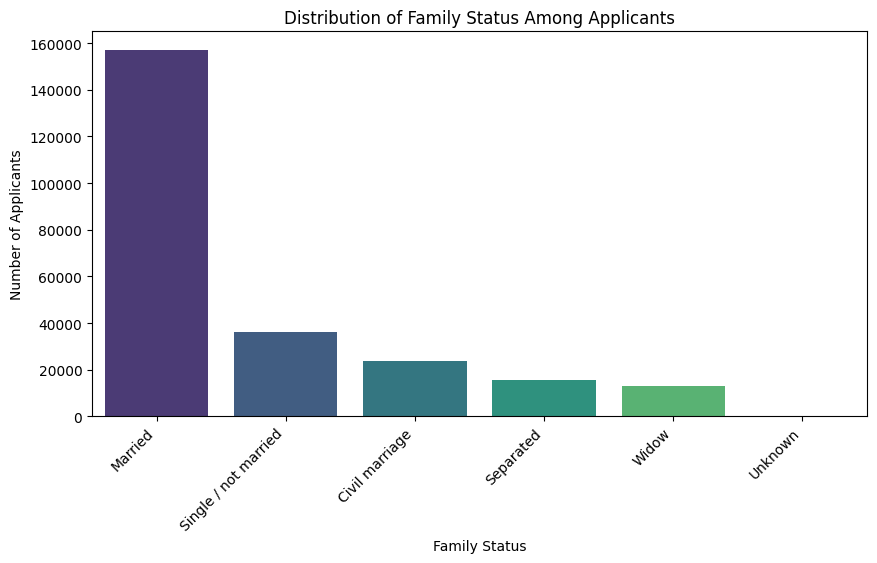

In [13]:
### TODO Complete in this cell: family status


# Count occurrences of each family status category
family_status_counts = train_df["NAME_FAMILY_STATUS"].value_counts()

# Print total counts
print(" Total count of each family status category:")
print(family_status_counts)

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=family_status_counts.index, y=family_status_counts.values, hue=family_status_counts.index, legend=False, palette="viridis")

# Add labels and title

plt.xticks(rotation=45, ha="right")
plt.xlabel("Family Status")
plt.ylabel("Number of Applicants")
plt.title("Distribution of Family Status Among Applicants")

# Show the plot
plt.show()



1.13. Plot the income type of applicants grouped by the target variable.

*Hint:* Take a look at `NAME_INCOME_TYPE` and `TARGET` columns. You can use `hue` parameter on Seaborn to group samples using another categorical feature.

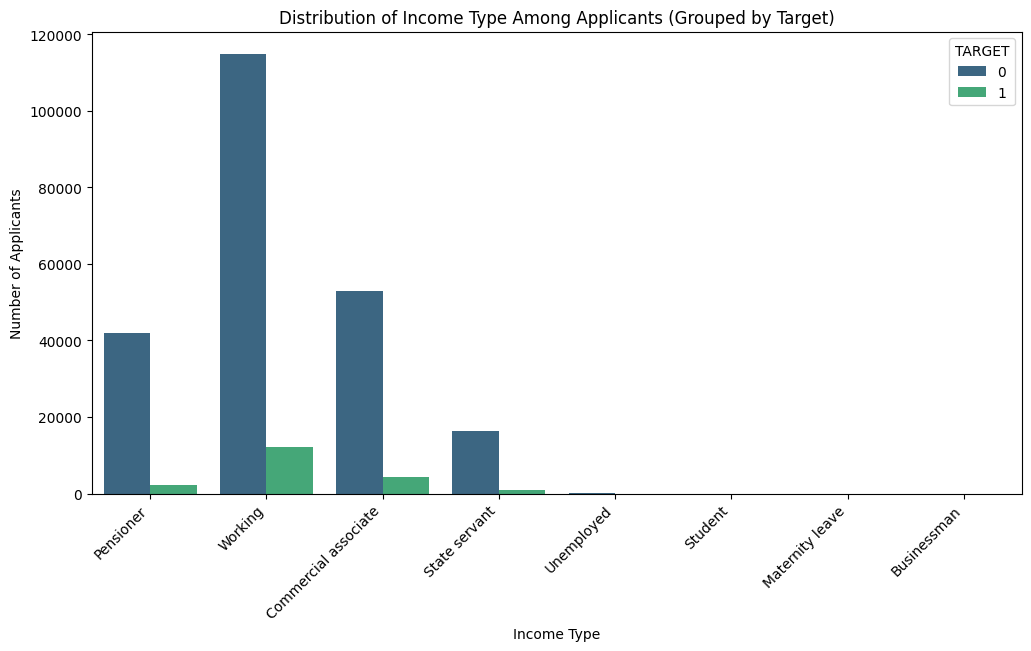

In [14]:
### TODO Complete in this cell: Income type of applicants by target variable

# Set figure size
plt.figure(figsize=(12, 6))

# Create count plot of income type grouped by target variable
sns.countplot(data=train_df, x="NAME_INCOME_TYPE", hue="TARGET", palette="viridis")

# Add labels and title
plt.xticks(rotation=45, ha="right")
plt.xlabel("Income Type")
plt.ylabel("Number of Applicants")
plt.title("Distribution of Income Type Among Applicants (Grouped by Target)")

# Show the plot
plt.show()


## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

- Assign to `X_train` all the columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` all the columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).

To do that, you will have to complete the function `data_utils.get_feature_target()` in all the parts with a `TODO` mark.


**Don't change anything in this cell, just make it run correctly**

In [15]:
import sys
sys.path.append("src")  # Agrega la carpeta "src" al path de Python

# Importar el módulo data_utils
import data_utils  

# Ejecutar la función
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


In [16]:
import pandas as pd

# Cargar los datasets desde la carpeta "dataset"
app_train = pd.read_csv("dataset/application_train_aai.csv")  # Ajusta la ruta si es necesario
app_test = pd.read_csv("dataset/application_test_aai.csv")  # Ajusta la ruta si es necesario

# Verificar que los datos se han cargado correctamente
print(" app_train shape:", app_train.shape)
print(" app_test shape:", app_test.shape)


 app_train shape: (246008, 122)
 app_test shape: (61503, 122)


In [18]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!


AttributeError: 'NoneType' object has no attribute 'shape'

2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`. 

While the `train` data will be used to fit the model and adjust its internal weights, the `validation` will be exclusively used to test the model performance on unseen data during training, it's like a testing dataset used during experimentation.

Remember we can't use the `test` dataset to validate the model performance because this one lacks of labels :( So the `validation` data will be the only resource you will have to evaluate the final model performance before doing your submission.

To do that, you will have to complete the function `data_utils.get_train_val_sets()` in all the parts with a `TODO` mark.

This function should perform these activities:
- Use the `sklearn.model_selection.train_test_split` function with `X_train`, `y_train` datasets.
- Assign only 20% of the dataset for testing (see `test_size` parameter in `train_test_split`)
- Assign a seed so we get reproducible output across multiple function calls (see `random_state` parameter in `train_test_split`)
- Shuffle the data (see `shuffle` parameter in `train_test_split`)

For reference, see:
- [Scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [Wikipedia: Training, validation, and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [Train Test Validation Split: How To & Best Practices](https://www.v7labs.com/blog/train-validation-test-set)


**Don't change anything in this cell, just make it run correctly**

In [19]:
# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

 X_train_new shape: ok (196806, 121)
 y_train_new shape: ok (196806,)
 X_val shape: ok (49202, 121)
 y_val shape: ok (49202,)
Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.3. In this section, you will code a function to make all the data pre-processing for the dataset. What you have to deliver is a function that takes `X_train`, `X_val`, and `X_test` dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities, in this order:

1. Correct outliers/anomalous values in numerical columns (`DAYS_EMPLOYED` column)
2. Encode string categorical features (dytpe `object`):
    - If the feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
3. Impute values for all columns with missing data (use median as imputing value)
4. Feature scaling with Min-Max scaler.

Complete the function `preprocessing.preprocess_data()` following the instructions given above.

In the following cell, we are going to execute the preprocessing function you've just coded. No need to modify this.

**Important Note:** From now on, you must always use `train_data` for training your models and `val_data` only for the final evaluation of the model trained. About `test_data`, it will be used at the end only for submitting your final model predictions and be evaluated on our side with the hidden annotations.


**Don't change anything in this cell, just make it run correctly**

In [20]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

 Input train data shape:  (196806, 121)
 Input val data shape:  (49202, 121)
 Input test data shape:  (61503, 121) 

Success: train_data shape is correct!
Success: train_data type is correct!
Success: val_data shape is correct!
Success: val_data type is correct!
Success: test_data shape is correct!
Success: test_data type is correct!


## 3. Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

**Pro tip:** It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend you to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

**Don't change anything in this cell, just make it run correctly**

In [21]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

CPU times: total: 5.44 s
Wall time: 2.77 s


LogisticRegression(C=0.0001)

**Don't change anything in this cell, just make it run correctly**

In [22]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


3.2. Use the trained model to predict probabilities for `train_data` and `val_data`.

**Important note:** When using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1). As an example, the result from running `predict_proba()` on validation dataset will have a shape of `(49202, 2)` but, we only need the second column from that matrix, which corresponds to the class 1.


**Don't change anything in this cell, just make it run correctly**

In [23]:
# Example code to show you how to use the Logistic Regression model
# to predict probabilities for each class and then, use the probabilities for the
# class 1 only.

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

3.3. Get AUC ROC score on train and validation datasets. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


**Don't change anything in this cell, just make it run correctly**

In [24]:
# Example code to show you how to get the ROC AUC Score on train and val datasets

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.6795
Validation ROC AUC Score: 0.6769


At this point, the model should produce a result of around 0.67.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

**Don't change anything in this cell, just make it run correctly**

In [25]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for `n_jobs`, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [26]:
# TODO Write your code here for training a Random Forest model.
#   - Please use sklearn.ensemble.RandomForestClassifier() class.
#   - Assign the model to the variable `rf`.
#   - Remember to fit the model only on `train_data`.
import time


# Medir tiempo de entrenamiento
start_time = time.time()

# Definir el modelo con n_jobs=-1 para usar todos los núcleos de la CPU
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Entrenar el modelo
rf.fit(train_data, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f" Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

 


 Tiempo de entrenamiento: 126.05 segundos


**Don't change anything in this cell, just make it run correctly**

In [27]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


3.5. Use the classifier to predict probabilities for `train_data` and `val_data`.

In [28]:
# TODO Use the Random Forest model to predict probabilities for each class and then,
# use the probabilities for the class 1 only.

# Train data predictions (class 1), Predecir probabilidades en train  
rf_pred_train = rf.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1), validation para la clase 1 (deuda NO pagada)
rf_pred_val = rf.predict_proba(val_data)[:, 1]

# Check dimension
print(" rf_pred_train shape: ok", rf_pred_train.shape)
print(" rf_pred_val shape: ok", rf_pred_val.shape)


 rf_pred_train shape: ok (196806,)
 rf_pred_val shape: ok (49202,)


3.6. Get AUC ROC score on train and validation datasets.


In [29]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score

roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f" Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_pred_val)
print(f" Validation ROC AUC Score: {roc_auc_val:.4f}")



 Train ROC AUC Score: 1.0000
 Validation ROC AUC Score: 0.7078


At this point, the model should produce a result around 0.7.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?
An AUC of 1.0 in training generally indicates overfitting (the model memorizes the training data and does not generalize well to new data). 

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


3.7. Use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model. 

The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

In [31]:
# Definir el modelo base
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    "n_estimators": [100, 200, 300],  # Número de árboles en el bosque
    "max_depth": [10, 20, 30, None],  # Profundidad máxima de los árboles
    "min_samples_split": [2, 5, 10],  # Mínimo de muestras requeridas para dividir un nodo
    "min_samples_leaf": [1, 2, 4],  # Mínimo de muestras requeridas en una hoja
    "bootstrap": [True, False],  # Si se usa o no bootstrap
}

# Configurar RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Número de combinaciones a probar
    scoring="roc_auc",  # Evaluamos usando AUC ROC
    cv=3,  # Validación cruzada con 3 folds
    verbose=2,  # Mostrar detalles del proceso
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos de la CPU
)

print(" `rf_random` ha sido configurado correctamente.")



 `rf_random` ha sido configurado correctamente.


In [33]:
# Entrenar el modelo con RandomizedSearchCV
rf_random.fit(train_data, y_train)

print(" `rf_random` ha sido entrenado correctamente.")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
 `rf_random` ha sido entrenado correctamente.


3.8. Use the classifier to predict probabilities on the train and test data.


In [34]:
# TODO Use the RandomizedSearchCV model to predict probabilities for each class and
# then, use the probabilities for the class 1 only.

# Train data predictions (class 1)(deuda NO pagada)
rf_tuned_pred_train = rf_random.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)(deuda NO pagada)
rf_tuned_pred_val = rf_random.predict_proba(val_data)[:, 1]

# Verificar dimensiones
print(" rf_tuned_pred_train shape:", rf_tuned_pred_train.shape)
print(" rf_tuned_pred_val shape:", rf_tuned_pred_val.shape)


 rf_tuned_pred_train shape: (196806,)
 rf_tuned_pred_val shape: (49202,)


3.9. Get AUC ROC score on train and validation datasets.

In [35]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score( EN EL CONJUNTO DE ENTRENAMIENTO)
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_tuned_pred_train)
print(f" Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score(EN EL CONJUNTO DE VALIDACION)
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_tuned_pred_val)
print(f" Validation ROC AUC Score: {roc_auc_val:.4f}")



 Train ROC AUC Score: 0.9998
 Validation ROC AUC Score: 0.7355


At this point, the model should produce a result around 0.7 or higher.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?                 

The optimized Random Forest model improved validation performance (AUC ROC = 0.7355).However, overfitting is still an issue (0.9998 in training).

This means the model memorized the training data too well but does not generalize effectively. A possible solution is to adjust hyperparameters, such as limiting tree depth or reducing the number of estimators, to improve generalization

## 4. Predict unlabeled data

Now it's time to finally use the `test_data` samples. Because we don't have the labels we can't see how the model performs on this dataset (╯°□°)╯︵ ┻━┻

But... don't worry, we will internally evaluate your model and give feedback on the results!

In the cells below:
- Take your best model
- Take `test_data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `TARGET` column in the `app_test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
    - `TARGET` column values must be the probabilities for class 1. So remember to use the `predict_proba()` function from your model as we did in the previous sections.
- Save the modified version of the DataFrame with the same name it has before (`dataset/application_test_aai.csv`) and don't forget to submit it alongside the rest of this sprint project code
- And finally, don't get confused, you shouldn't submit `dataset/application_train_aai.csv`. So please don't upload your solution with this heavy dataset inside.

Let's say your best model is called `best_credit_model_ever`, then your code should be exactly this:

```python
    test_preds = best_credit_model_ever.predict_proba(test_data)[:, 1]
    app_test["TARGET"] = test_preds
    app_test.to_csv(config.DATASET_TEST, index=False)
```


In [36]:
# TODO Use your best model and call the predict_proba() on test_data then,
# use the probabilities for the class 1 only.
# Then, put the predictions in app_test["TARGET"] and save the DataFrame as a csv
# with the same name it originally has ("application_test_aai.csv").
import time

# Medir el tiempo de predicción
start_time = time.time()

# Hacer predicciones en test_data (solo probabilidad de clase 1)
test_preds = rf_random.predict_proba(test_data)[:, 1]

# Guardar las predicciones en la columna TARGET del DataFrame app_test
app_test["TARGET"] = test_preds

# Guardar el DataFrame modificado como CSV (sin el índice)
app_test.to_csv("dataset/application_test_aai.csv", index=False)

# Medir tiempo de ejecución
end_time = time.time()
elapsed_time = end_time - start_time

print(f" Predicciones generadas y guardadas en 'dataset/application_test_aai.csv'.")
print(f" Tiempo total de predicción: {elapsed_time:.2f} segundos")



 Predicciones generadas y guardadas en 'dataset/application_test_aai.csv'.
 Tiempo total de predicción: 15.19 segundos


## 5. Optional exercises

### Optional: Training a LightGBM model 

5.1. Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [38]:
### Complete in this cell: train a LightGBM model
import lightgbm as lgb
import time

# Medir el tiempo de entrenamiento
start_time = time.time()

# Crear el modelo LightGBM
lgbm = lgb.LGBMClassifier(
    n_estimators=500,  # Número de árboles
    learning_rate=0.05,  # Tasa de aprendizaje
    max_depth=10,  # Profundidad máxima del árbol
    num_leaves=31,  # Número de hojas en cada árbol
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos del CPU
)

# Entrenar el modelo en los datos de entrenamiento
lgbm.fit(train_data, y_train)

# Medir el tiempo final
end_time = time.time()
elapsed_time = end_time - start_time

print(f" Modelo LightGBM entrenado correctamente en {elapsed_time:.2f} segundos")



[LightGBM] [Info] Number of positive: 15784, number of negative: 181022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11604
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080201 -> initscore=-2.439622
[LightGBM] [Info] Start training from score -2.439622
 Modelo LightGBM entrenado correctamente en 25.55 segundos


In [39]:


# Calcular AUC ROC en entrenamiento
lgbm_pred_train = lgbm.predict_proba(train_data)[:, 1]
roc_auc_train = roc_auc_score(y_train, lgbm_pred_train)

# Calcular AUC ROC en validación
lgbm_pred_val = lgbm.predict_proba(val_data)[:, 1]
roc_auc_val = roc_auc_score(y_val, lgbm_pred_val)

# Mostrar resultados
print(f" Train ROC AUC Score: {roc_auc_train:.4f}")
print(f" Validation ROC AUC Score: {roc_auc_val:.4f}")


c:\Users\pc\Desktop\Sprint_2-Alfredo- Arocena\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\pc\Desktop\Sprint_2-Alfredo- Arocena\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Train ROC AUC Score: 0.8586
 Validation ROC AUC Score: 0.7532


LightGBM significantly improves validation performance (AUC = 0.7532), outperforming Random Forest (0.7355).
- Less overfitting compared to Random Forest (Train AUC reduced from 0.9998 to 0.8586).
- Much faster and more efficient (trained in 25.55 seconds vs. 57 minutes for Random Forest).

conclusion:
LightGBM is the best model so far, offering a great balance between performance and efficiency.



### Optional: Using Scikit Learn Pipelines 

5.2. So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [44]:
# Crear DataFrames sin especificar columnas
train_data_df = pd.DataFrame(train_data)
val_data_df = pd.DataFrame(val_data)
test_data_df = pd.DataFrame(test_data)

# Identificar columnas numéricas y categóricas nuevamente
num_features = train_data_df.select_dtypes(include=["int64", "float64"]).columns
cat_features = train_data_df.select_dtypes(include=["object"]).columns


In [45]:
### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training
import time
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Medir el tiempo de entrenamiento
start_time = time.time()

# Crear transformaciones para el preprocesamiento
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Imputar valores faltantes con la mediana
    ("scaler", MinMaxScaler())  # Escalar valores entre 0 y 1
])

cat_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # Codificar variables categóricas
])

# Aplicar transformaciones a las columnas correspondientes
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

# Crear el Pipeline con preprocesador y Random Forest
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

# Entrenar el modelo con el Pipeline
pipeline.fit(train_data_df, y_train)

# Medir el tiempo final
end_time = time.time()
elapsed_time = end_time - start_time

print(f"✅ Modelo con Pipeline entrenado correctamente en {elapsed_time:.2f} segundos")




✅ Modelo con Pipeline entrenado correctamente en 157.84 segundos


In [46]:
from sklearn.metrics import roc_auc_score

# Obtener predicciones de probabilidad para la clase 1 (deuda NO pagada)
pipeline_pred_train = pipeline.predict_proba(train_data_df)[:, 1]
pipeline_pred_val = pipeline.predict_proba(val_data_df)[:, 1]

# Calcular AUC ROC Score en entrenamiento y validación
roc_auc_train = roc_auc_score(y_train, pipeline_pred_train)
roc_auc_val = roc_auc_score(y_val, pipeline_pred_val)

# Mostrar resultados
print(f" Train ROC AUC Score: {roc_auc_train:.4f}")
print(f" Validation ROC AUC Score: {roc_auc_val:.4f}")


 Train ROC AUC Score: 1.0000
 Validation ROC AUC Score: 0.7159


The Pipeline model is overfitting. The Train ROC AUC is 1.0000, meaning the model memorized training data.
This indicates poor generalization to new data. Validation AUC (0.7159) is lower than LightGBM (0.7532).

LightGBM remains the best-performing model in terms of generalization.
Final conclusion:
LightGBM is still the top model, as it offers the best balance between training and validation performance.

### Optional: Build your own model and features

5.3. If you want you can take the original labeled data given and make your own feature selection, data preprocessing, and model tunning. Be creative, the only limit is time and hardware resources. Only be careful and don't modify the previous functions made in the mandatory assignments or, you will break the project tests.

You can even use this newer model to make predictions in the test dataset with hidden labels and submit that.


In [47]:
### Complete in this cell: Make you own experimentation process
# Ver porcentaje de valores nulos en cada columna
missing_values = train_data_df.isnull().mean() * 100

# Mostrar las 20 columnas con más valores nulos
print(" Top 20 columnas con más valores nulos:")
print(missing_values.sort_values(ascending=False).head(20))

# Definir umbral para eliminar columnas con muchos valores nulos (ejemplo: >50%)
threshold = 50  
columns_to_drop = missing_values[missing_values > threshold].index

# Eliminar columnas con demasiados valores nulos
train_data_filtered = train_data_df.drop(columns=columns_to_drop)
val_data_filtered = val_data_df.drop(columns=columns_to_drop)
test_data_filtered = test_data_df.drop(columns=columns_to_drop)

print(f" Columnas eliminadas: {len(columns_to_drop)}")
print(f" Nuevo shape del train dataset: {train_data_filtered.shape}")


 Top 20 columnas con más valores nulos:
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
dtype: float64
 Columnas eliminadas: 0
 Nuevo shape del train dataset: (196806, 246)


In [48]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# Definir el modelo LightGBM con hiperparámetros optimizados
lgbm_optimized = lgb.LGBMClassifier(
    n_estimators=500,  
    learning_rate=0.05,  
    max_depth=10,  
    num_leaves=31,  
    colsample_bytree=0.8,  
    subsample=0.8,  
    random_state=42
)

# Entrenar el modelo
lgbm_optimized.fit(train_data_df, y_train)

# Predecir probabilidades en entrenamiento y validación
lgbm_pred_train = lgbm_optimized.predict_proba(train_data_df)[:, 1]
lgbm_pred_val = lgbm_optimized.predict_proba(val_data_df)[:, 1]

# Calcular AUC ROC Score
roc_auc_train = roc_auc_score(y_train, lgbm_pred_train)
roc_auc_val = roc_auc_score(y_val, lgbm_pred_val)

# Mostrar resultados
print(f" Train ROC AUC Score: {roc_auc_train:.4f}")
print(f" Validation ROC AUC Score: {roc_auc_val:.4f}")


[LightGBM] [Info] Number of positive: 15784, number of negative: 181022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11604
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080201 -> initscore=-2.439622
[LightGBM] [Info] Start training from score -2.439622
 Train ROC AUC Score: 0.8564
 Validation ROC AUC Score: 0.7544


In [50]:
import pandas as pd

# Obtener la importancia de cada característica del modelo entrenado
feature_importances = pd.Series(
    lgbm_optimized.feature_importances_, index=train_data_df.columns
).sort_values(ascending=False)

# Seleccionar solo las características con importancia mayor a 5
selected_features = feature_importances[feature_importances > 5].index

# Filtrar los datasets con estas columnas
train_data_selected = train_data_df[selected_features]
val_data_selected = val_data_df[selected_features]
test_data_selected = test_data_df[selected_features]

print(f"✅ Nuevo shape del dataset: {train_data_selected.shape}")


✅ Nuevo shape del dataset: (196806, 176)


In [51]:
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a probar
param_grid = {
    "n_estimators": [300, 500, 700],  # Número de árboles
    "learning_rate": [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    "max_depth": [8, 10, 12],  # Profundidad máxima del árbol
    "num_leaves": [20, 31, 40],  # Número de hojas
    "subsample": [0.7, 0.8, 0.9],  # Submuestreo
    "colsample_bytree": [0.7, 0.8, 0.9],  # Proporción de columnas utilizadas
}

# Configurar el modelo
lgbm = lgb.LGBMClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,  # Número de folds en cross-validation
    verbose=2,
    n_jobs=-1
)

# Ejecutar la búsqueda
grid_search.fit(train_data_selected, y_train)

# Mostrar mejores hiperparámetros encontrados
print("✅ Mejores hiperparámetros encontrados:", grid_search.best_params_)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[LightGBM] [Info] Number of positive: 15784, number of negative: 181022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11485
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080201 -> initscore=-2.439622
[LightGBM] [Info] Start training from score -2.439622
✅ Mejores hiperparámetros encontrados: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 20, 'subsample': 0.7}


In [52]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# Definir el modelo con los mejores hiperparámetros
lgbm_best = lgb.LGBMClassifier(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    num_leaves=20,
    subsample=0.7,
    random_state=42
)

# Entrenar el modelo con los datos optimizados
print("Entrenando el modelo optimizado...")
lgbm_best.fit(train_data_selected, y_train)

# Predecir probabilidades en train y val
train_preds = lgbm_best.predict_proba(train_data_selected)[:, 1]
val_preds = lgbm_best.predict_proba(val_data_selected)[:, 1]

# Calcular métricas AUC ROC
roc_auc_train = roc_auc_score(y_train, train_preds)
roc_auc_val = roc_auc_score(y_val, val_preds)

# Mostrar resultados
print(f"✅ Train ROC AUC Score: {roc_auc_train:.4f}")
print(f"✅ Validation ROC AUC Score: {roc_auc_val:.4f}")


Entrenando el modelo optimizado...
[LightGBM] [Info] Number of positive: 15784, number of negative: 181022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11485
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 176
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080201 -> initscore=-2.439622
[LightGBM] [Info] Start training from score -2.439622
✅ Train ROC AUC Score: 0.8024
✅ Validation ROC AUC Score: 0.7550
